# Adversarial Attacks to AI Art Tools

There's been a couple mini-viral tweets on how to not let an AI use your images, one of which was a "anti-ai filter" that had to deal with adding noise to your image. I found the original image they used to make this claim and it was from a Tensorflow blog post about Adversarial Examples with the Fast Gradient Sign Method (FGSM) for ResNET Image Classification.

![](https://www.tensorflow.org/static/tutorials/generative/images/adversarial_example.png)

Obviously this will not work out of the box for Stable Diffusion (idk in what way they were expecting it to), but I explored making the encoding process (for img2img or more generally for encoding to diffuse) output an undesirable result. This worked only to a degree.

This notebook includes code for this and a couple more. Each are to be used as separate instances because libraries may conflix, each have their own setup cells. Under "Runtime" there is a "Disconnect and delete runtime" option which you'll want to hit each time you are going to switch techniques.
(some of this code is old, and all of it is very dirty and hacky)
<br><br>
totally real license: do whatever you want with it, tag me if you come up with something cool

\- [aicrumb](https://twitter.com/aicrumb)

## VQGAN Encoding Attack

This optimizes the encoding loss from the original encoding to the encoding of a slightly noised image

(example thread) https://twitter.com/aicrumb/status/1580440734192148481

In [1]:
#@title Install required libraries / Log in to the 🤗 hub
import os
from IPython.display import clear_output
import time
if not os.path.exists("installed.txt"):
    !pip install transformers diffusers accelerate -q
    !sudo apt-get install git-lfs
    !cat "test" > installed.txt
    !mkdir /content/output
    print("Installed libraries")
    time.sleep(1)
    clear_output(wait=False)
else:
    print("Libraries already installed.")

#@markdown Base stable diffusion is "CompVis/stable-diffusion-v1-4". <br>
model_name = "CompVis/stable-diffusion-v1-4" #@param {"type":"string"}

from huggingface_hub import notebook_login
notebook_login()

Libraries already installed.


In [2]:
#@title Import libraries
import torch
torch.manual_seed(0)
from diffusers import AutoencoderKL
from IPython.display import Image, display
from tqdm.auto import tqdm, trange
from torch import autocast
import PIL.Image as PImage
import numpy
from torchvision import transforms
import torchvision.transforms.functional as f
import random
import requests
from io import BytesIO

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


reconstructed normal input


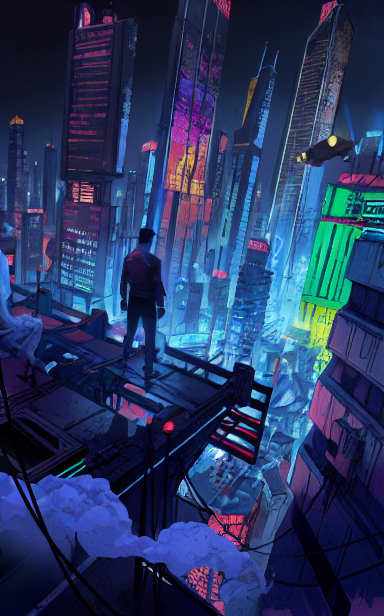

In [5]:
#@title load vae / functions / image
vae = AutoencoderKL.from_pretrained(model_name, subfolder="vae", use_auth_token=True).cuda()
vae = vae.half()
to_tensor_tfm = transforms.ToTensor()

def encode(input_im):
    with autocast("cuda"):
        latent = vae.encode((input_im).unsqueeze(0).to(torch_device)*2-1).latent_dist
    return 0.18215 * latent.sample() # or .mean or .sample

def scale_and_decode(latents):
    with autocast("cuda"):
        latents = 1 / 0.18215 * latents
        image = vae.decode(latents).sample.squeeze(0)
        image = image / 2 + 0.5
        return image

def fetch(url_or_path):
    import io
    if str(url_or_path).startswith('http://') or str(url_or_path).startswith('https://'):
        r = requests.get(url_or_path)
        r.raise_for_status()
        fd = io.BytesIO()
        fd.write(r.content)
        fd.seek(0)
        return PImage.open(fd).convert('RGB')
    return PImage.open(open(url_or_path, 'rb')).convert('RGB')

url = "https://cdnb.artstation.com/p/assets/images/images/032/142/769/large/ignacio-bazan-lazcano-book-4-final.jpg" #@param {type:"string"}
pil_image = fetch(url)
pil_image = pil_image.convert("RGB")

#@markdown <br>So the instance doesn't go OOM:
image_min_size = 384 #@param
pil_image = transforms.functional.resize(pil_image, image_min_size)
with torch.no_grad():
    encoded_image = encode(to_tensor_tfm(pil_image).cuda()) 

print("reconstructed normal input")
transforms.functional.to_pil_image((scale_and_decode(encoded_image.half()).clamp(0, 1)))

the noise generated
the noise generated


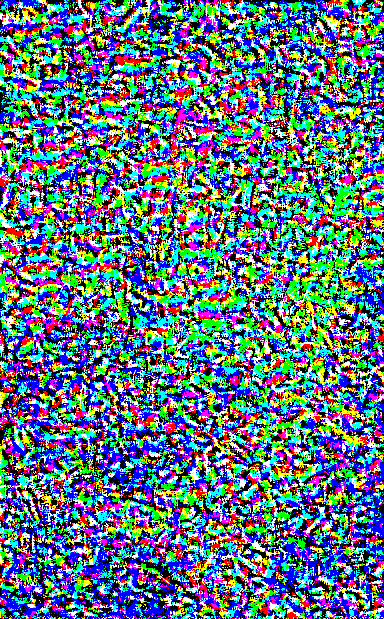

In [6]:
#@title optimize noise
with torch.no_grad():
    input = to_tensor_tfm(pil_image).cuda()
    z = torch.randn(input.shape, requires_grad=True, device='cuda')
    target = encode(input).detach()
input_noise = z
input_image = input + input_noise
encoded = encode(input_image)
similarity_to_target = (encoded - target).pow(2).mean()
loss = -similarity_to_target
loss = loss + (input_image-input_image.clamp(0, 1)).pow(2).mean()
loss.backward()
#@title optimize noise
with torch.no_grad():
    input = to_tensor_tfm(pil_image).cuda()
    z = torch.randn(input.shape, requires_grad=True, device='cuda')
    target = encode(input).detach()
input_noise = z
input_image = input + input_noise
encoded = encode(input_image)
similarity_to_target = (encoded - target).pow(2).mean()
loss = -similarity_to_target
loss = loss + (input_image-input_image.clamp(0, 1)).pow(2).mean()
loss.backward()

noise = torch.sign(z.grad / z.grad.max())

print("the noise generated")
transforms.functional.to_pil_image((noise))
noise = torch.sign(z.grad / z.grad.max())

print("the noise generated")
transforms.functional.to_pil_image((noise))

reconstruction of the image when the noise is added at scale 0.01


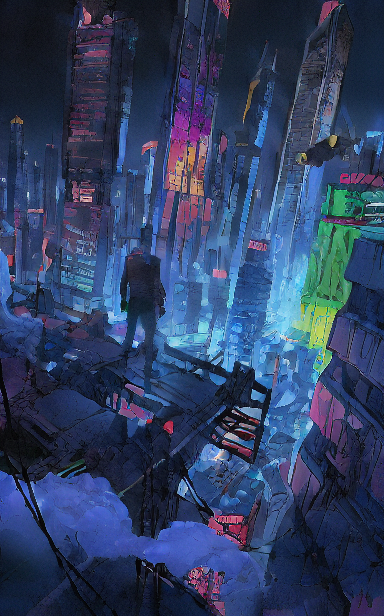

In [7]:
#@title add noise / test decode

noise = torch.randn_like(to_tensor_tfm(pil_image)).cuda()

a = 0.01 #@param
noise = noise * a
with torch.no_grad():
    output = scale_and_decode(encode(to_tensor_tfm(pil_image).cuda() + noise).clamp(-1,1)).clamp(0, 1)
print("reconstruction of the image when the noise is added at scale", a)
transforms.functional.to_pil_image(output)

the normal image with the noise added


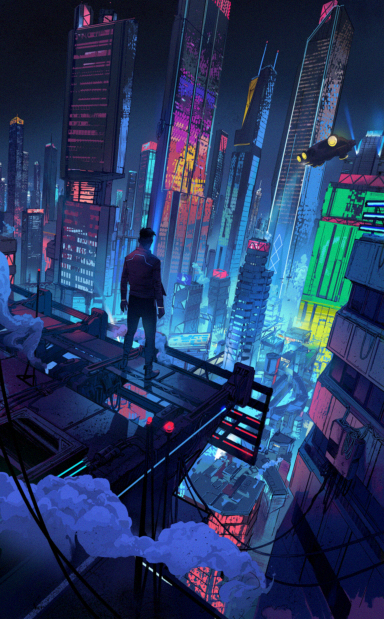

In [8]:
#@title the image with the noise added (before decode)
print("the normal image with the noise added")
transforms.functional.to_pil_image((to_tensor_tfm(pil_image).cuda() + noise).clamp(0, 1))

## Interrogator/CLIP Attack 1

This attacks CLIP with FGSM to make the embedding as far from the normal embedding as possible

Overall: Doesn't work well for Interrogator, does work well for CLIP embedding? I dunno run it. Maybe my code is buggy.

In [1]:
#@title Setup
!pip3 install ftfy regex tqdm transformers==4.15.0 timm==0.4.12 fairscale==0.4.4
!pip3 install git+https://github.com/openai/CLIP.git
!git clone -b v1 https://github.com/pharmapsychotic/clip-interrogator.git
!git clone https://github.com/salesforce/BLIP
%cd /content/BLIP

import clip
import gc
import numpy as np
import os
import pandas as pd
import requests
import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF

from IPython.display import display
from PIL import Image
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
from models.blip import blip_decoder

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

blip_image_eval_size = 384
blip_model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model*_base_caption.pth'        
blip_model = blip_decoder(pretrained=blip_model_url, image_size=blip_image_eval_size, vit='base')
blip_model.eval()
blip_model = blip_model.to(device)

def generate_caption(pil_image):
    gpu_image = transforms.Compose([
        transforms.Resize((blip_image_eval_size, blip_image_eval_size), interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
    ])(image).unsqueeze(0).to(device)

    with torch.no_grad():
        caption = blip_model.generate(gpu_image, sample=False, num_beams=3, max_length=20, min_length=5)
    return caption[0]

def load_list(filename):
    with open(filename, 'r', encoding='utf-8', errors='replace') as f:
        items = [line.strip() for line in f.readlines()]
    return items

def rank(model, image_features, text_array, top_count=1):
    top_count = min(top_count, len(text_array))
    text_tokens = clip.tokenize([text for text in text_array]).cuda()
    with torch.no_grad():
        text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

    similarity = torch.zeros((1, len(text_array))).to(device)
    for i in range(image_features.shape[0]):
        similarity += (100.0 * image_features[i].unsqueeze(0) @ text_features.T).softmax(dim=-1)
    similarity /= image_features.shape[0]

    top_probs, top_labels = similarity.cpu().topk(top_count, dim=-1)  
    return [(text_array[top_labels[0][i].numpy()], (top_probs[0][i].numpy()*100)) for i in range(top_count)]

def interrogate(image, models):
    caption = generate_caption(image)
    if len(models) == 0:
        print(f"\n\n{caption}")
        return

    table = []
    bests = [[('',0)]]*5
    for model_name in models:
        print(f"Interrogating with {model_name}...")
        model, preprocess = clip.load(model_name)
        model.cuda().eval()

        images = preprocess(image).unsqueeze(0).cuda()
        with torch.no_grad():
            image_features = model.encode_image(images).float()
        image_features /= image_features.norm(dim=-1, keepdim=True)

        ranks = [
            rank(model, image_features, mediums),
            rank(model, image_features, ["by "+artist for artist in artists]),
            rank(model, image_features, trending_list),
            rank(model, image_features, movements),
            rank(model, image_features, flavors, top_count=3)
        ]

        for i in range(len(ranks)):
            confidence_sum = 0
            for ci in range(len(ranks[i])):
                confidence_sum += ranks[i][ci][1]
            if confidence_sum > sum(bests[i][t][1] for t in range(len(bests[i]))):
                bests[i] = ranks[i]

        row = [model_name]
        for r in ranks:
            row.append(', '.join([f"{x[0]} ({x[1]:0.1f}%)" for x in r]))

        table.append(row)

        del model
        gc.collect()
    display(pd.DataFrame(table, columns=["Model", "Medium", "Artist", "Trending", "Movement", "Flavors"]))

    flaves = ', '.join([f"{x[0]}" for x in bests[4]])
    medium = bests[0][0][0]
    if caption.startswith(medium):
        print(f"\n\n{caption} {bests[1][0][0]}, {bests[2][0][0]}, {bests[3][0][0]}, {flaves}")
    else:
        print(f"\n\n{caption}, {medium} {bests[1][0][0]}, {bests[2][0][0]}, {bests[3][0][0]}, {flaves}")

data_path = "../clip-interrogator/data/"

artists = load_list(os.path.join(data_path, 'artists.txt'))
flavors = load_list(os.path.join(data_path, 'flavors.txt'))
mediums = load_list(os.path.join(data_path, 'mediums.txt'))
movements = load_list(os.path.join(data_path, 'movements.txt'))

sites = ['Artstation', 'behance', 'cg society', 'cgsociety', 'deviantart', 'dribble', 'flickr', 'instagram', 'pexels', 'pinterest', 'pixabay', 'pixiv', 'polycount', 'reddit', 'shutterstock', 'tumblr', 'unsplash', 'zbrush central']
trending_list = [site for site in sites]
trending_list.extend(["trending on "+site for site in sites])
trending_list.extend(["featured on "+site for site in sites])
trending_list.extend([site+" contest winner" for site in sites])

from IPython.display import clear_output
clear_output()

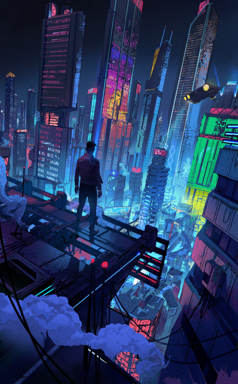

Interrogating with ViT-L/14...


,Model,Medium,Artist,Trending,Movement,Flavors
0,ViT-L/14,cyberpunk art (93.4%),by James Gilleard (9.1%),cgsociety (60.3%),retrofuturism (47.4%),"synthwave (23.9%), cityscape (23.2%), 2d game ..."




a man standing on top of a bridge over a city, cyberpunk art by James Gilleard, cgsociety, retrofuturism, synthwave, cityscape, 2d game art


In [2]:
#@title Interrogate!

#@markdown #####**Image:**

image_path_or_url = "https://cdnb.artstation.com/p/assets/images/images/032/142/769/large/ignacio-bazan-lazcano-book-4-final.jpg" #@param {type:"string"}

# only use one at a time
ViTB32 = False
ViTB16 = False 
ViTL14 = True
ViTL14_336px = False 
RN101 = False
RN50 = False
RN50x4 = False
RN50x16 = False
RN50x64 = False

models = []
if ViTB32: models.append('ViT-B/32')
if ViTB16: models.append('ViT-B/16')
if ViTL14: models.append('ViT-L/14')
if ViTL14_336px: models.append('ViT-L/14@336px')
if RN101: models.append('RN101')
if RN50: models.append('RN50')
if RN50x4: models.append('RN50x4')
if RN50x16: models.append('RN50x16')
if RN50x64: models.append('RN50x64')

if str(image_path_or_url).startswith('http://') or str(image_path_or_url).startswith('https://'):
    image = Image.open(requests.get(image_path_or_url, stream=True).raw).convert('RGB')
else:
    image = Image.open(image_path_or_url).convert('RGB')

thumb = image.copy()
thumb.thumbnail([blip_image_eval_size, blip_image_eval_size])
display(thumb)

interrogate(image, models=models)

Interrogating with ViT-L/14...
the noise generated (not full resolution, don't use this as a copy to copy/paste, just tick "show full res noise")


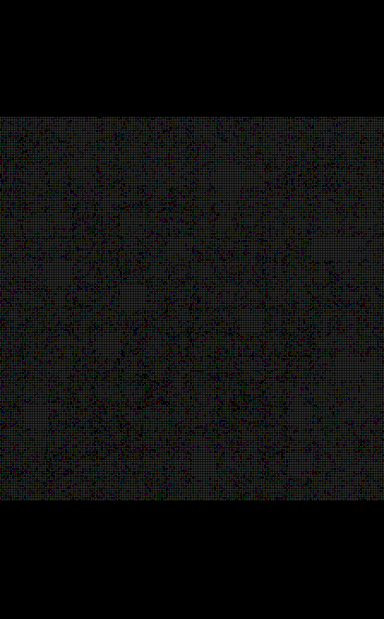

In [3]:
#@title generate noise
import torchvision.transforms.functional as tf
from torch.nn import functional as F
from torchvision.transforms import Compose, Resize, CenterCrop, Normalize
from torchvision.transforms import InterpolationMode
BICUBIC = InterpolationMode.BICUBIC
def sph_dist(x, y):
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    l = (x - y).norm(dim=-1).div(2).arcsin().pow(2).mul(2).mean()
    return l 

if str(image_path_or_url).startswith('http://') or str(image_path_or_url).startswith('https://'):
    image = Image.open(requests.get(image_path_or_url, stream=True).raw).convert('RGB')
else:
    image = Image.open(image_path_or_url).convert('RGB')

def _transform(n_px=224):
    # this should be equivelant to what it's doing
    return Compose([
        Resize(n_px, interpolation=BICUBIC),
        CenterCrop(n_px),
        Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
    ])
preprocess = _transform()

model_name = models[0]
print(f"Interrogating with {model_name}...")
model, _ = clip.load(model_name)
model.cuda().eval()
image = tf.to_tensor(image.convert("RGB"))
z = torch.randn(image.shape, requires_grad=True, device='cuda')
cropped_image = preprocess(image)
cropped_z = preprocess(z)
with torch.no_grad():
    image_features = model.encode_image(cropped_image.cuda().unsqueeze(0)).float()
    image_features /= image_features.norm(dim=-1, keepdim=True)
z_features = model.encode_image(cropped_z.unsqueeze(0)).float()
z_features = z_features / z_features.norm(dim=-1, keepdim=True).clone().detach()

loss_fn = "dot product similarity" #@param ["dot product similarity", "spherical distance loss"]
if loss_fn=="spherical distance loss":
    similarity = -sph_dist(z_features, image_features)
else:
    similarity = (image_features @ z_features.T)
    similarity = similarity / image_features.shape[1] # this probably doesnt matter
similarity.backward()

noise = torch.sign(z.grad)

print("the noise generated (not full resolution, don't use this as a copy to copy/paste, just tick \"show full res noise\")")
show_full_res_noise = False #@param {type:"boolean"}
if not show_full_res_noise:
    j = tf.resize(tf.to_pil_image(noise), 384)
else:
    j = tf.to_pil_image(noise)
j

Spherical Distance Loss from noised image embedding to original image embedding: 0.5910159945487976
the image generated (not full resolution, don't use this as a copy to copy/paste, just tick "show full res noised image")
Image saved to "watermarked.png"


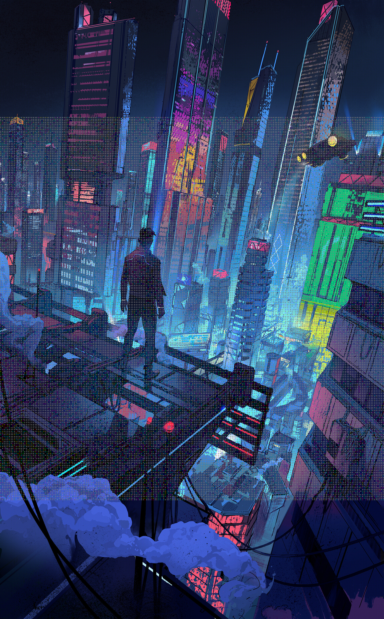

In [4]:
#@title add noise to image
show_full_res_noised_image = False #@param {type:"boolean"}
# a = 0.75 #@param

noised_image = noise + image.cuda()*(noise==0).float()

tf.to_pil_image(noised_image).save("watermarked.png")
noised_image = Image.open("watermarked.png")
noised_image = tf.to_tensor(noised_image).cuda()

with torch.no_grad():
    emb = model.encode_image(preprocess(noised_image).unsqueeze(0)).float()
    print("Spherical Distance Loss from noised image embedding to original image embedding:", sph_dist(emb, image_features).item())

print("the image generated (not full resolution, don't use this as a copy to copy/paste, just tick \"show full res noised image\")")
if not show_full_res_noised_image:
    j = tf.resize(tf.to_pil_image(noised_image), 384)
else:
    j = tf.to_pil_image(noised_image)

print("Image saved to \"watermarked.png\"")
j

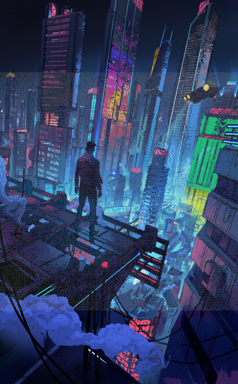

Interrogating with ViT-L/14...


,Model,Medium,Artist,Trending,Movement,Flavors
0,ViT-L/14,cyberpunk art (88.9%),by James Gilleard (22.1%),cgsociety (64.8%),retrofuturism (49.7%),"cityscape (18.9%), synthwave (12.8%), dystopia..."




a man standing on top of a tall building, cyberpunk art by James Gilleard, cgsociety, retrofuturism, cityscape, synthwave, dystopian art


In [3]:
#@title Interrogate!

#@markdown you may have to restart runtime + run setup + run this because of memory constraints.
# del model

#@markdown #####**Image:**

image_path_or_url = "/content/BLIP/watermarked.png" #@param {type:"string"}

ViTB32 = False
ViTB16 = False 
ViTL14 = True
ViTL14_336px = False 
RN101 = False
RN50 = False
RN50x4 = False
RN50x16 = False
RN50x64 = False

models = []
if ViTB32: models.append('ViT-B/32')
if ViTB16: models.append('ViT-B/16')
if ViTL14: models.append('ViT-L/14')
if ViTL14_336px: models.append('ViT-L/14@336px')
if RN101: models.append('RN101')
if RN50: models.append('RN50')
if RN50x4: models.append('RN50x4')
if RN50x16: models.append('RN50x16')
if RN50x64: models.append('RN50x64')

if str(image_path_or_url).startswith('http://') or str(image_path_or_url).startswith('https://'):
    image = Image.open(requests.get(image_path_or_url, stream=True).raw).convert('RGB')
else:
    image = Image.open(image_path_or_url).convert('RGB')

thumb = image.copy()
thumb.thumbnail([blip_image_eval_size, blip_image_eval_size])
display(thumb)

interrogate(image, models=models)

## CLIP Attack 2

Adds the word "IPod" on top of your image. Inspired by an example from an OpenAI blog post. You can find the blog post here: https://openai.com/blog/multimodal-neurons/

![](https://i0.wp.com/boingboing.net/wp-content/uploads/2021/03/apple-ipod-final-1.jpg?fit=762%2C479&ssl=1)

In [45]:
#@title load image & model
!pip install git+https://github.com/openai/CLIP -q
from PIL import Image, ImageDraw, ImageFont
import requests 
import clip
import torch 
image_path_or_url = "https://cdnb.artstation.com/p/assets/images/images/032/142/769/large/ignacio-bazan-lazcano-book-4-final.jpg" #@param {type:"string"}

if str(image_path_or_url).startswith('http://') or str(image_path_or_url).startswith('https://'):
    image = Image.open(requests.get(image_path_or_url, stream=True).raw).convert('RGB')
else:
    image = Image.open(image_path_or_url).convert('RGB')

clip_model_name = "ViT-L/14" #@param ["ViT-L/14", "ViT-L/14+336", "ViT-B/16", "ViT-B/32", "RN50x64", "RN50x16", "RN50x4", "RN101", "RN50"]
clip_model, preprocess = clip.load(clip_model_name, jit=False)

with torch.no_grad():
    normal_emb = clip_model.encode_image(preprocess(image).unsqueeze(0).cuda())

In [46]:
#@title write text on image
w, h = image.size
x, y = (w//2, h//2)
I1 = ImageDraw.Draw(image)
r_g_b = (255, 255, 255) #@param

!wget -O font.zip https://www.fontsquirrel.com/fonts/download/SeasideResortNF
!unzip -o font.zip
from IPython.display import clear_output
clear_output()

myFont = ImageFont.truetype('/content/SEASRN__.ttf', size=min([w,h])//4)
I1.text((x-(w//4), y), "IPod", fill=r_g_b, font=myFont)

('Predicted probability that the image is the original image:', '33.4375%')
('Predicted probability that the image is an IPod', '66.5625%')



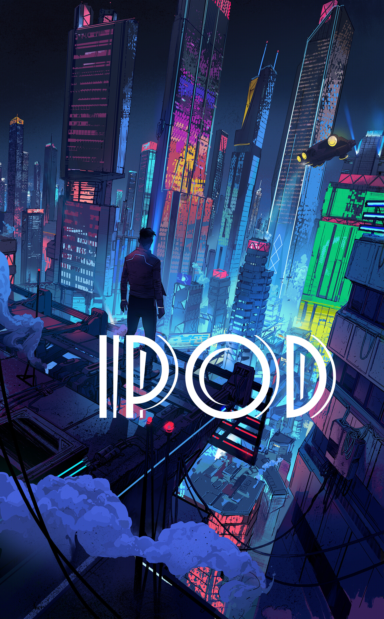

In [49]:
from torch.nn import functional as F
def sph_dist(x, y):
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    l = (x - y).norm(dim=-1).div(2).arcsin().pow(2).mul(2)
    return l 

show_full_res_image = False #@param {type:"boolean"}

with torch.no_grad():
    new_embedding = clip_model.encode_image(preprocess(image).cuda().unsqueeze(0))
    ipod_embedding = clip_model.encode_text(clip.tokenize("IPod").cuda())
    targets = torch.cat([normal_emb, ipod_embedding], 0)
    scores = sph_dist(new_embedding, targets)
    scores = torch.softmax(scores, -1)
# print("Probability of image being the original vs the image being IPod")
for i in zip(
    ["Predicted probability that the image is the original image:", "Predicted probability that the image is an IPod"],
    [str(i)+"%" for i in scores.mul(100).tolist()]
):
    print(i)
print()

if show_full_res_image:
    j = image
else:
    import torchvision
    j = torchvision.transforms.functional.resize(image, 384)
j